# Read CoLoRe skewers and play with them (including crude transformations to flux)

Note that the transformations to flux are obsolete, but leaving this here in case people want to learn history

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import lya_mock_functions as mock
import lya_stats_functions as stats

In [2]:
#Open data file
hdulist = fits.open('../example_data/raw_colore_1000/out_srcs_s1_0.fits')

#Extract redshift from data file
z = hdulist[4].data['Z']
z = np.asarray(z)

In [3]:
#Get number of quasars, and redshift array
z_qso = hdulist[1].data['Z_COSMO']
N_qso = len(z_qso)
print('There are %d quasars in the sample.' % N_qso)

There are 1000 quasars in the sample.


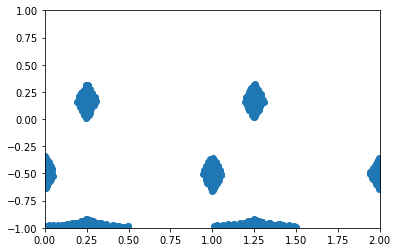

In [4]:
#Plot the locations of the quasars according to the HEALPix pixel grid.
RA = hdulist[1].data['RA']
DEC = hdulist[1].data['DEC']
phi = RA*np.pi/180
theta = np.pi/2 - DEC*np.pi/180
plt.figure()
plt.scatter(phi/np.pi,np.cos(theta))
plt.xlim(0.0,2.0)
plt.ylim(-1.0,1.0)
plt.show()

In [5]:
#Extract the delta skewers from the file, and make a mask for them.
delta_skewers = hdulist[2].data
mask = stats.make_mask(z,z_qso)

print('Mean of all deltas = {}'.format(np.average(delta_skewers,weights=mask)))

Mean of all deltas = -0.008073619783209241


In [6]:
#NORMALISE THE DELTA FIELD SO THAT ITS MEAN IS 0.
#THIS IS AN ONGOING ISSUE IN COLORE, AND IS LISTED TO BE FIXED SO THAT THE DELTA MEAN IS 0 AUTOMATICALLY.
delta_skewers = stats.normalise_delta(mask,delta_skewers)
print('Mean of all deltas = {}'.format(np.average(delta_skewers,weights=mask)))

Mean of all deltas = -1.6939406582884956e-08


In [7]:
#Get the length of each skewer.
N_pix_skewer = hdulist[2].data.shape[1]
print('There are %d pixels in each skewer.' % N_pix_skewer)

There are 2048 pixels in each skewer.


In [8]:
#Show the structure of the data
print(hdulist[2].header.keys)

<bound method Header.iterkeys of XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 1000                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
CONTENTS= 'gaussian skewers'                                                    
EXTNAME = 'DENSITY SKEWERS'    / extension name                                 >


In [9]:
#Get delta for the highest redshift quasar in the sample.
id = np.argmax(hdulist[1].data['Z_COSMO'])
delta = delta_skewers[id,:]

mean delta = 0.040956333668472754
var delta = 1.2544825


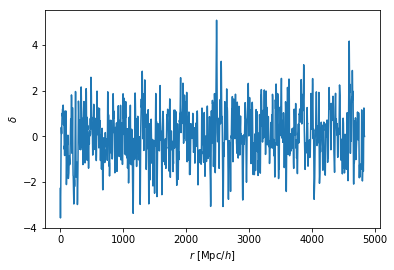

In [10]:
#Show delta vs r
print('mean delta =', np.average(delta,weights=mask[id]))
print('var delta =', np.var(delta))
plt.figure()
plt.plot(hdulist[4].data['R'],hdulist[2].data[id])
plt.xlabel('$r\\,\\,[{\\rm Mpc}/h]$')
plt.ylabel('$\\delta$')
plt.show()

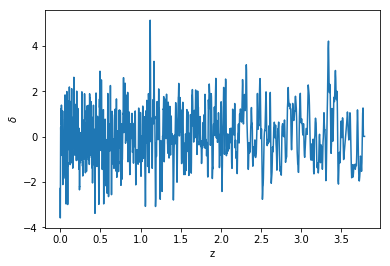

In [11]:
#Show delta vs z
plt.figure()
plt.plot(z,delta)
plt.xlabel('z')
plt.ylabel('$\\delta$')
plt.show()

mean density = 1.0414884
var density = 1.2544825


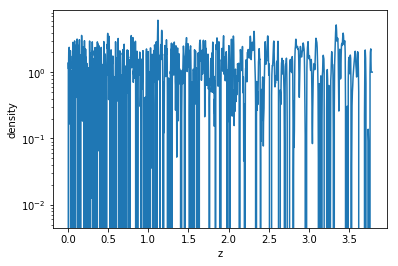

In [12]:
#Show density vs z
density = (delta + 1)
print('mean density =', np.mean(density))
print('var density =', np.var(density))
plt.figure()
plt.semilogy(z,density)
plt.xlabel('z')
plt.ylabel('density')
plt.show()

mean tau = 0.10562441
var tau = 0.093134426


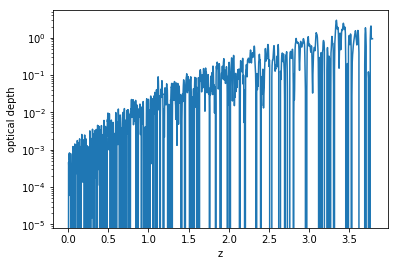

In [13]:
#Convert from a lognormal density field to optical depth
tau = mock.get_tau(z,density)
print('mean tau =', np.mean(tau))
print('var tau =', np.var(tau))
plt.figure()
plt.semilogy(z,tau)
plt.xlabel('z')
plt.ylabel('optical depth')
plt.show()

mean flux = 0.9303058
var flux = 0.03555437
 


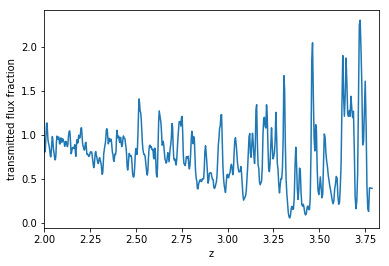

In [14]:
#Convert from optical depth to transmitted flux fraction
flux = np.exp(-tau)
print('mean flux =', np.mean(flux))
print('var flux =', np.var(flux))
plt.figure()
plt.plot(z,flux)
plt.xlabel('z')
plt.ylabel('transmitted flux fraction')
plt.xlim(2,1.01*max(z))
print(" ")
plt.show()

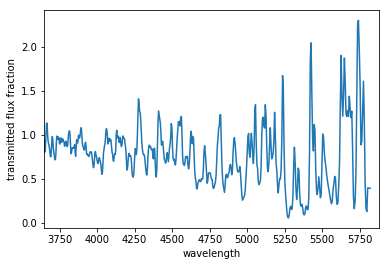

In [15]:
#Show a test skewer spectrum
wavelength = 1215.67*(1+z)
plt.figure()
plt.plot(wavelength,flux)
plt.xlabel('wavelength')
plt.ylabel('transmitted flux fraction')
plt.xlim(1215.67*(1+2),1.01*max(wavelength))
print(" ")
plt.show()

In [16]:
#Calculate density statistics
binned_z, binned_mean_density, binned_density_var, binned_delta_var = stats.density_stats(z,z_qso,(hdulist[2].data)+1)

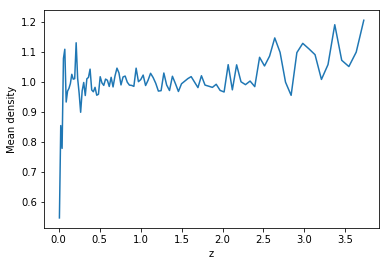

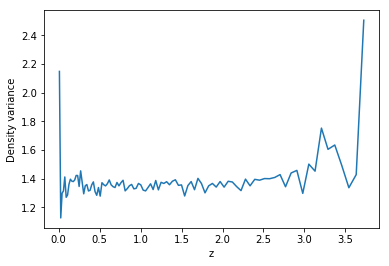

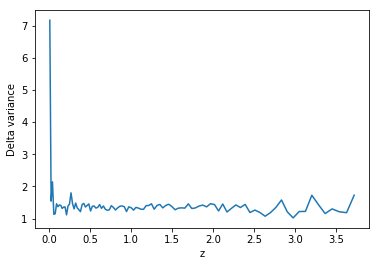

In [17]:
#Show the calculated statistics against z
plt.figure()
plot_binned_mean_density = plt.plot(binned_z, binned_mean_density)
plt.xlabel('z')
plt.ylabel('Mean density')
plt.figure()
plot_binned_density_var = plt.plot(binned_z, binned_density_var)
plt.xlabel('z')
plt.ylabel('Density variance')
plt.figure()
plot_binned_delta_var = plt.plot(binned_z, binned_delta_var)
plt.xlabel('z')
plt.ylabel('Delta variance')
print(" ")
plt.show()

In [18]:
#Define redshift bin boundaries: zhb(0)<=z<zhb(1), zhb(1)<=z<zhb(2) etc.
z_hist_bins_boundaries = [0,1,2,3]
N_bins = len(z_hist_bins_boundaries)

/home/font/anaconda3/envs/desi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


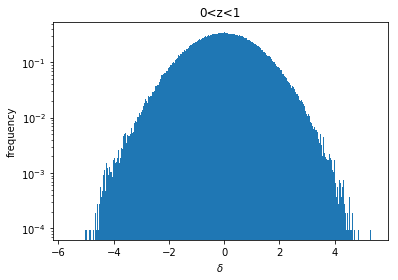

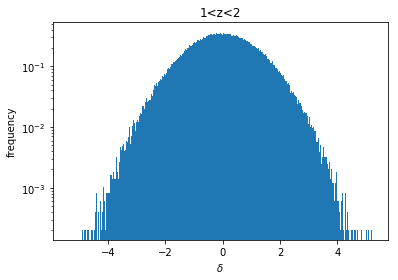

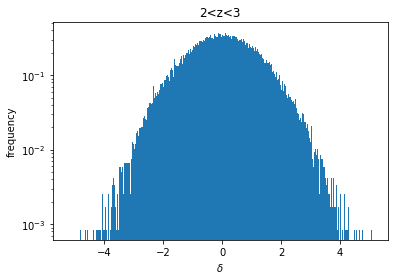

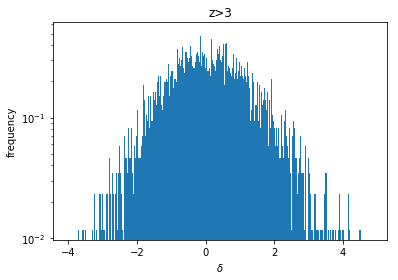

In [19]:
#Show a sequence of histograms of delta.
lower_bound = [0]*N_bins
upper_bound = [0]*N_bins

for i in range(N_bins):
    #get boundaries in skewer length terms
    lower_bound[i] = max(np.argmax(z>z_hist_bins_boundaries[i])-1,0)
    if i+1 < N_bins:
        upper_bound[i] = np.argmax(z>z_hist_bins_boundaries[i+1])-1
    else:
        upper_bound[i] = len(z)-1

    #print histogram
    plt.figure()
    plt.hist(np.ravel(hdulist[2].data[:,lower_bound[i]:upper_bound[i]]),bins=1000,weights=np.ravel(mask[:,lower_bound[i]:upper_bound[i]]),normed=True)
    plt.yscale('log',nonposy='clip')
    plt.xlabel('$\\delta$')
    plt.ylabel('frequency')
    
    if i+1 < N_bins:
        plt.title('{}<z<{}'.format(z_hist_bins_boundaries[i], z_hist_bins_boundaries[i+1]))
    else:
        plt.title('z>{}'.format(z_hist_bins_boundaries[i]))
        
    plt.show()